# PRACTICE EXAMPLE

## Data Understanding

In this first part, we will try to show how to carry out a **Data Understanding** analysis that will allow us to fully understand the data and draw conclusions that will help us decide how to process the data.

The objective of the analysis has been explained above, but the objective of the project in which this analysis is framed would be to estimate the price of a second-hand vehicle based on specific data about the vehicle and its condition.

First, we will import the Python libraries that will be necessary to perform the analysis:

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from scipy import stats

### 1. General analysis of the dataset

The next step is to load our original dataset containing the data we are going to work with. We will perform an initial inspection of the data by displaying the first 10 records. To do this, in order to avoid null values appearing, since we only want to see what the data looks like (when there is data...), we remove only the records with more than one null value for this instruction.

In [6]:
# Load the dataset from the CSV file
data = pd.read_csv('vehicles_red.csv')

# Setting to show all columns
pd.set_option('display.max_columns', None)

# Display the first rows of the dataset, omitting rows that have more than one NaN.
data.dropna(thresh=data.shape[1] - 1).head(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,county,state,lat,long,posting_date
126,7305672709,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,NaN,al,31.425091,-85.617723,2021-04-12T11:20:35-0500
127,7305672266,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,NaN,al,31.425091,-85.617723,2021-04-12T11:20:00-0500
128,7305672252,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,NaN,al,31.425091,-85.617723,2021-04-12T11:19:58-0500
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,NaN,al,33.913500,-84.685900,2021-05-03T17:48:17-0500
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,NaN,al,33.353800,-86.825400,2021-05-03T16:03:27-0500


In view of the data shown, we can comment on the variables:
- **id**: record identification number. Each record refers to a vehicle and its id is unique throughout the dataset.
- **region**: US region where the vehicle is sold.
- **price**: sale price
- **year**: year in which the vehicle was manufactured
- **manufacturer**: manufacturer
- **model**: model
- **condition**: condition of the vehicle
- **cylinders**: number of engine cylinders
- **fuel**: type of fuel used
- **odometer**: mileage of the vehicle since manufacture
- **title_status**: legal status of the vehicle
- **transmission**: type of transmission used by the car
- **VIN**: vehicle identification number
- **drive**: type of vehicle drive
- **size**: size
- **type**: body type
- **paint_color**: vehicle paint colour
- **state**: GPS latitude coordinate
- **lat**: GPS longitude coordinate
- **long**: date and time the sale advertisement was posted in the last 30 days
- **posting_date**: date and time of upload of the sale advertisement in the last 30 days

Now let's take a closer look at the dataset by examining the dimensions and some additional information, such as the data types for each column.

In [8]:
# Provide an initial description of the dataset
data.info()  # General information about columns, data types, and non-null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  county        0 non-null       float64
 18  stat

We have a total of 22 variables and a volume of 426,880 records. As for data types, we see that almost all variables are categorical, with a few exceptions.

### 2. Analysis of numerical variables

We will now examine the numerical variables in the dataset in greater detail. To do so, we will calculate some basic statistics that give us a broad overview of the distributions of values for our three variables that we consider to be truly numerical and for which we can detect anomalies:

In [11]:
# Remove irrelevant numerical columns
data.drop(columns=['lat','long','id','county'], inplace=True)

In [12]:
# Descriptive statistics (mean, standard deviation, minimum, maximum, etc.)
print(data.describe())

              price           year      odometer
count  4.268800e+05  425675.000000  4.224800e+05
mean   7.519903e+04    2011.235191  9.804333e+04
std    1.218228e+07       9.452120  2.138815e+05
min    0.000000e+00    1900.000000  0.000000e+00
25%    5.900000e+03    2008.000000  3.770400e+04
50%    1.395000e+04    2013.000000  8.554800e+04
75%    2.648575e+04    2017.000000  1.335425e+05
max    3.736929e+09    2022.000000  1.000000e+07


We now have only three numerical variables to study. All of them reveal interesting information:

- **price**: from the statistics, we can see that all records have values. The average price is `$`75199, which seems very different from the median value (50th percentile), which is `$`13,950. This difference may be due to a significant asymmetry in the distribution and/or the presence of outliers. Given that the 75th percentile is still below the mean at £26,485 and that the maximum value is an exorbitant `$`3,736,929,000, the presence of outliers is clearly affecting certain statistics such as the mean and the standard deviation, which is `$`12,182,270. The outliers and erroneous values of this variable will need to be studied very carefully.
- **year**: the year shows more normal statistics in general, although with some uncertainties. On the other hand, we see that on average the cars were manufactured in 2011, very close to their median in 2013. The maximum value is 2022, which seems reasonable and will be the date up to which data has been collected in this set. However, the minimum value of 1900 will need to be examined to see whether values so far back in time make sense and, if so, what to do with them.
- **odometer**: this variable also shows problems associated with outliers or erroneous values. In this case, looking at the maximum mileage, values such as 10,000,000 km seem unreasonable. This is clearly an error.

### 3. Anomaly detection

Now that we know there are possible anomalies in the dataset, we proceed to apply the methods learned in theory to detect these anomalies.

#### 3.1 Graphical Methods

Let us now look at the graphical distributions of these variables using histograms.

We are going to create a variable that records the numerical variables we have. This will be useful when we want to iterate over them several times.

Numerical variables:  ['price' 'year' 'odometer']


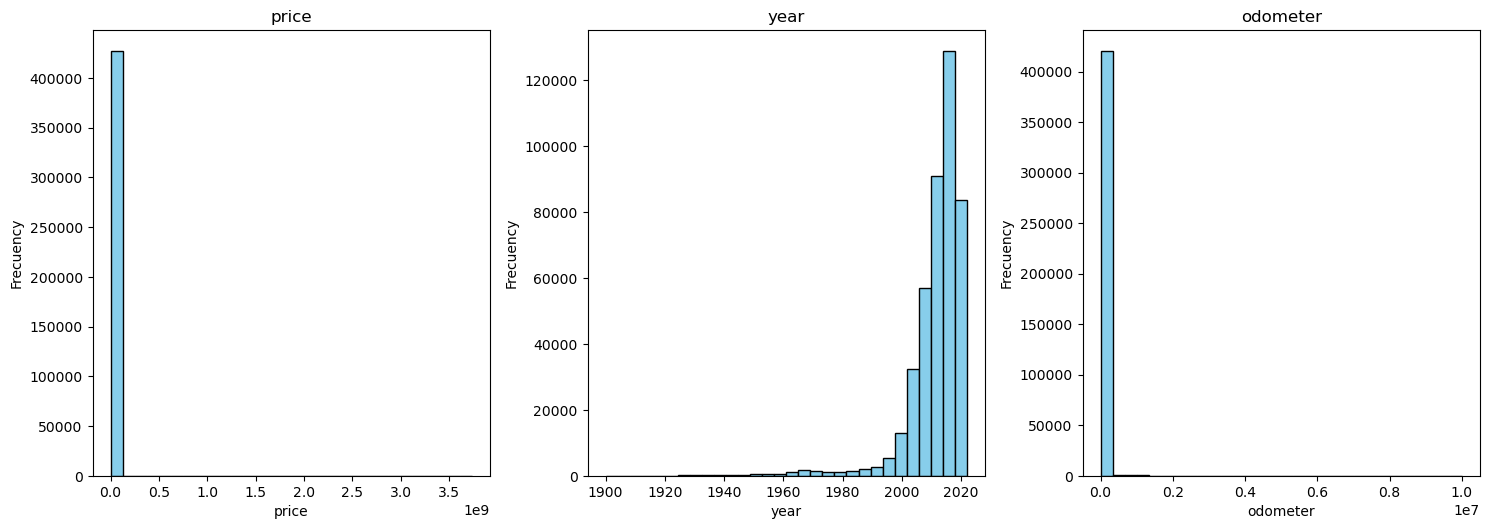

In [18]:
# Identify the numerical columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
print("Numerical variables: ", numeric_columns.values)

# Create a figure with subplots
num_vars = len(numeric_columns)
fig, axes = plt.subplots(nrows=(num_vars // 3) + 1, ncols=3, figsize=(15, 5 * ((num_vars // 3) + 1)))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    # Plot the histogram
    axes[i].hist(data[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuency')

# Remove redundant axes if there are fewer than 3 variables.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

In this case, we can see that there are a number of outliers for the variables ***price*** and ***odometer***, as it is impossible to view the histograms properly. For the variable ***year***, we can see the distribution of the data more or less clearly, although there may be certain anomalies relating to past years. It is a clearly asymmetrical distribution that grows exponentially from the 1990s onwards. It peaks around 2015.

#### 3.2 Statistical Methods

Let's analyze the three variables using two criteria and see what conclusions the differences between them lead us to. The first criterion will be to use the Z-Score metric (k standard deviations from the mean).

##### 3.2.1 - Z-score

We will start using Z-score = 3. Choosing a z-score of 3 means that any value that is more than 3 standard deviations away from the mean is considered an outlier.

In a normal distribution, almost 99.7% of the data is within ±3 standard deviations, so anything beyond that is very rare.
That’s why a z-score of 3 is used to detect only extreme outliers.

We can also change the Z-score depending on how restrictive the method is. A smaller Z-score means that we are less restrictive.

Lower threshold: -36471604.680666566
Upper threshold: 36622002.747041196


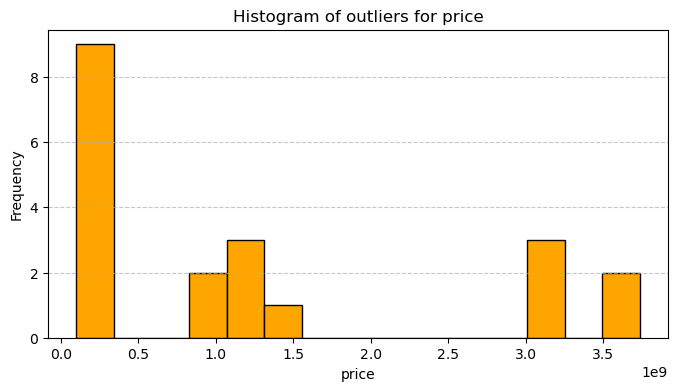

Lower threshold: 1982.8788657300038
Upper threshold: 2039.5915166039363


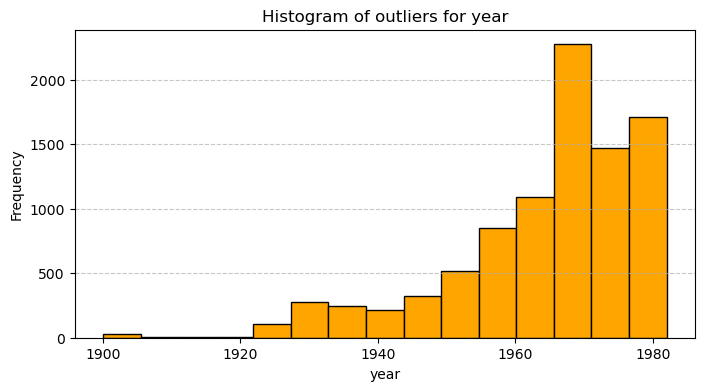

Lower threshold: -543600.4115720693
Upper threshold: 739687.0744578863


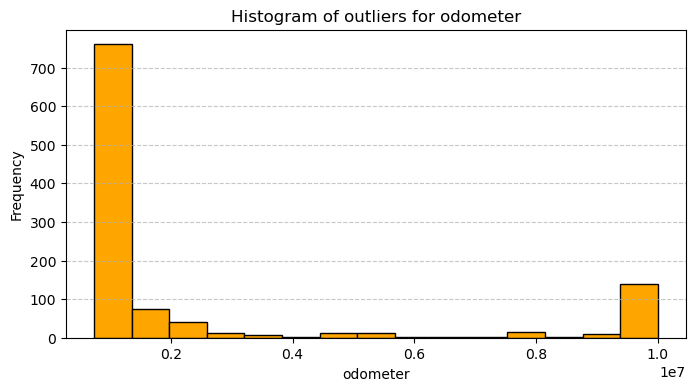


Identified outliers:
   Variable Outliers
0     price       20
1      year     9116
2  odometer     1089


In [24]:
# Outlier identification (Z-score)
outliers = pd.DataFrame(columns=['Variable', 'Outliers'])

for i, column in enumerate(numeric_columns):
    z_scores = np.abs(stats.zscore(data[column], nan_policy='omit'))
    outlier_indices = np.where(z_scores > 3)[0]
    
    # Calculate mean and standard deviation
    mu = np.mean(data[column])
    sigma = np.std(data[column])
    
    # Calculate values corresponding to Z-score 3 and -3
    upper_bound = 3 * sigma + mu
    lower_bound = -3 * sigma + mu
    print(f"Lower threshold: {lower_bound}")
    print(f"Upper threshold: {upper_bound}")
    
    if len(outlier_indices) > 0:
        new_row = pd.DataFrame({'Variable': [column],
                                'Outliers': [len(outlier_indices)]})
        outliers = pd.concat([outliers, new_row], ignore_index=True)
        
        # Plot histogram of outlier values
        plt.figure(figsize=(8, 4))
        plt.hist(data[column].iloc[outlier_indices], bins=15, color='orange', edgecolor='black')
        plt.title(f'Histogram of outliers for {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

print("\nIdentified outliers:")
print(outliers)


Using the Z-Score criterion, we obtained 20 outliers in the price variable corresponding to price values above $36,622,002. For the year variable, 9,116 outliers were found, all of them below the year 1982. Finally, in the odometer variable, we detected 1,089 corresponding to vehicles with more than 739,687 km.

At first glance, it seems that the detection of these outliers is somewhat demanding for the year variable, as there may be older cars being sold second-hand, yet for the other two variables, the thresholds seem a little lax. In other words, we are probably missing some outliers below these thresholds, as 36 million seems a slightly exaggerated figure for the price, as does 700,000 km.

##### 3.2.2 - Interquartil Range 

Let's try the second criterion, which consists of evaluating outliers based on the Interquartil Range (IQR). In these case, we will look for outliers greater than the upper and lower IQR range of 1.5.

Sing 1.5 × IQR is a rule to detect outliers.

    The IQR is: IQR = Q3 - Q1

Q1 = 25th percentile / Q3 = 75th percentile

Then we define limits:

- Lower bound=Q1−(1.5×IQR)
- Upper bound=Q3+(1.5×IQR)

Any value below Q1 – (1.5 × IQR) or above Q3 + (1.5 × IQR) is considered an outlier.

As Z-score method, we can vary the interquartile range depending on how restrictive it is for each case

Q1 (25th percentile): 5900.0
Q3 (75th percentile): 26485.75
IQR range: 20585.75
Lower threshold: -24978.625
Upper threshold: 57364.375


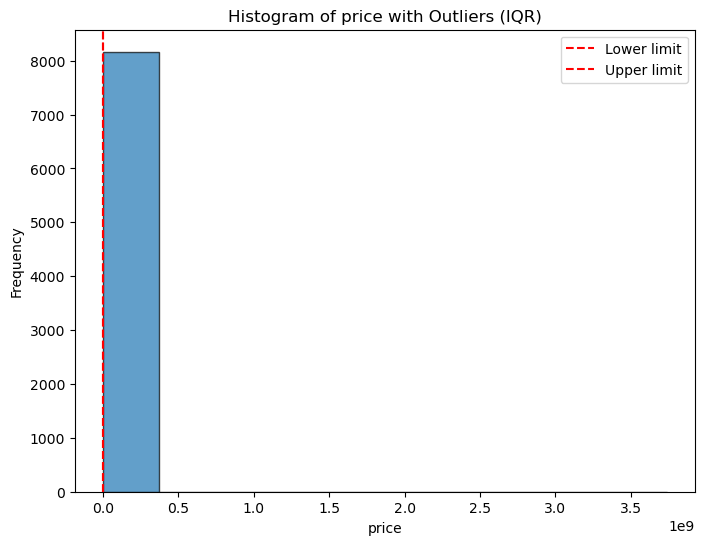

Q1 (25th percentile): 2008.0
Q3 (75th percentile): 2017.0
IQR range: 9.0
Lower threshold: 1994.5
Upper threshold: 2030.5


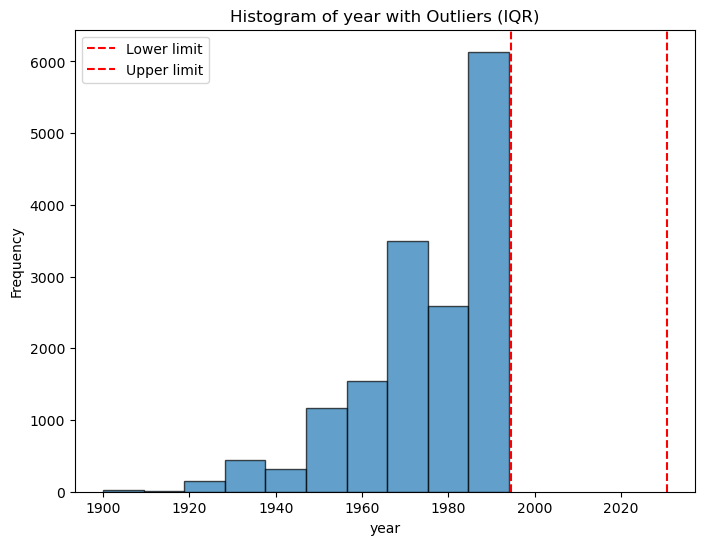

Q1 (25th percentile): 37704.0
Q3 (75th percentile): 133542.5
IQR range: 95838.5
Lower threshold: -106053.75
Upper threshold: 277300.25


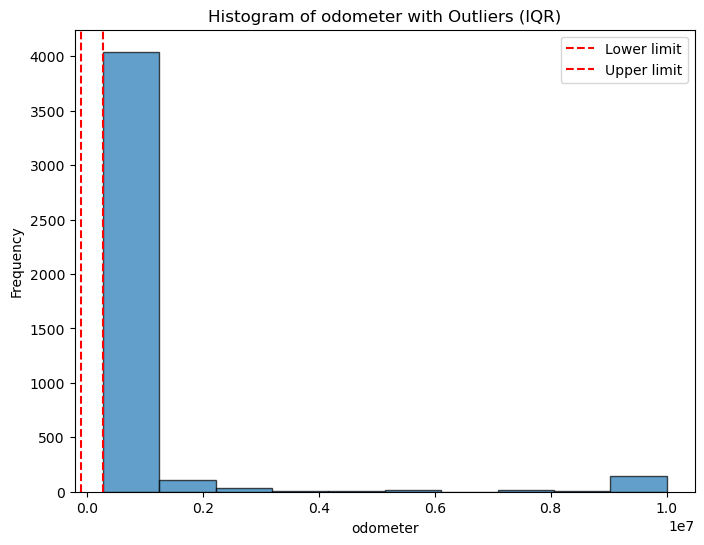


Outliers identified using IQR:
   Variable Outliers
0     price     8177
1      year    15896
2  odometer     4385


In [28]:
# Outlier identification using the IQR method
outliers = pd.DataFrame(columns=['Variable', 'Outliers'])

for i, column in enumerate(numeric_columns):
    data_col_dropna = data[column].dropna()
    Q1 = data_col_dropna.quantile(0.25)  # First quartile
    Q3 = data_col_dropna.quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range
    
    # Outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outlier_values = data_col_dropna[(data_col_dropna < lower_bound) | (data_col_dropna > upper_bound)]
    
    if len(outlier_values) > 0:
        new_row = pd.DataFrame({'Variable': [column],
                                'Outliers': [len(outlier_values)]})
        outliers = pd.concat([outliers, new_row], ignore_index=True)

        print(f"Q1 (25th percentile): {Q1}")    
        print(f"Q3 (75th percentile): {Q3}")
        print(f"IQR range: {IQR}")
        print(f"Lower threshold: {lower_bound}")
        print(f"Upper threshold: {upper_bound}")

        # Plot histogram of outliers
        plt.figure(figsize=(8, 6))
        plt.hist(outlier_values, bins=10, edgecolor='black', alpha=0.7)
        plt.axvline(lower_bound, color='r', linestyle='--', label='Lower limit')
        plt.axvline(upper_bound, color='r', linestyle='--', label='Upper limit')
        plt.title(f"Histogram of {column} with Outliers (IQR)")
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

# Show the outlier results
print("\nOutliers identified using IQR:")
print(outliers)


With this new criterion, the thresholds for detecting outliers are much more demanding. For ***year***, the previous criterion was already too strict, so this one, setting the lower threshold at 1994, is very restrictive. For the other two, although they are more appropriate, it seems that we have gone a little too far, since, for example, an upper threshold of $57,490 seems too low, given that many cars will have prices slightly above that. The same applies to mileage: 276,856 km is not such an unreasonable figure for used cars; it seems to be a fairly common value in sales of this type. These strict thresholds are what have increased the number of outliers in ***price*** from 20 to 8,177 and in ***odometer*** from 1,089 to 4,385.

By applying one criterion to some and another to others, we will surely find a middle ground. In addition, we have the possibility of adjusting the criteria if we consider it appropriate by modifying the value of the algorithm that determines the conditions (Z-Score in one and k times IQR in the other). 

#### 3.3 Density-based Methods

##### 3.3.1 DBSCAN

In this example, we will identify outliers in a dataset using the DBSCAN algorithm (Density-Based Spatial Clustering of Applications with Noise).
Unlike statistical methods like Z-score or IQR, DBSCAN does not assume a specific distribution and detects outliers as points that do not belong to any sufficiently dense cluster.

We will focus on the variables price and year, standardizing the data so that differences in scale do not affect clustering.
Points labeled -1 by DBSCAN will be considered outliers and visualized in a plot for easier interpretation.

Outliers detected by DBSCAN (subsample):

          price    year  DBSCAN_label
46533     14000  1948.0            -1
426313    55000  1957.0            -1
234516    42999  1975.0            -1
292253    56500  1960.0            -1
263157    13000  1939.0            -1
285893    54900  1969.0            -1
233201  1000000  2016.0            -1
383175   244999  2019.0            -1
336640    12000  1947.0            -1
352992   229500  2018.0            -1
36182     53333  1968.0            -1
370083    12345  1934.0            -1
350876     5900  1946.0            -1
14464     89000  1967.0            -1
2922     140000  2015.0            -1
343414    13000  1932.0            -1
400416    14500  1938.0            -1
321932   159995  2021.0            -1
176115   299991  2017.0            -1
43011     87888  1997.0            -1
337418   106999  2021.0            -1


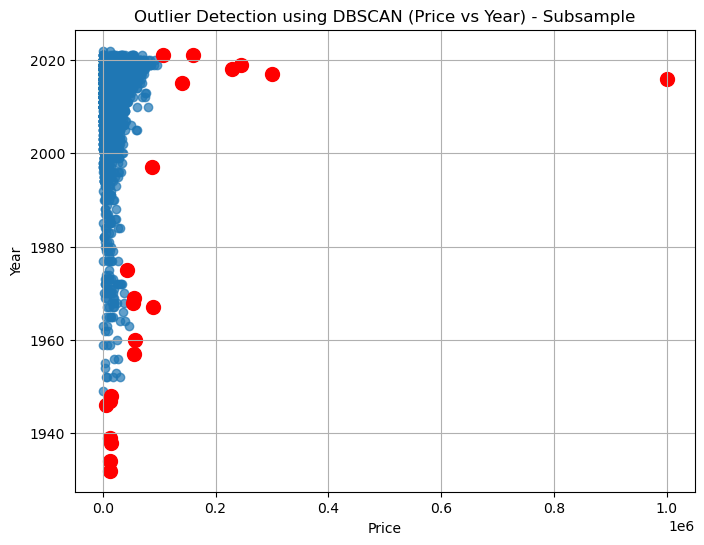

In [33]:
# Select variables
df = data[['price', 'year']].copy()

# Remove missing values
df_clean = df.dropna()

# Take a subsample if dataset is very large
df_sample = df_clean.sample(n=5000, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_sample)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

# Add DBSCAN labels to the subsample dataframe
df_sample['DBSCAN_label'] = labels

# Identify outliers
outliers = df_sample[df_sample['DBSCAN_label'] == -1]

print("Outliers detected by DBSCAN (subsample):\n")
print(outliers)

# Plot results
plt.figure(figsize=(8, 6))

# Normal points (cluster >= 0)
plt.scatter(
    df_sample[df_sample['DBSCAN_label'] != -1]['price'],
    df_sample[df_sample['DBSCAN_label'] != -1]['year'],
    alpha=0.7,
    label="Cluster"
)

# Outliers
plt.scatter(
    df_sample[df_sample['DBSCAN_label'] == -1]['price'],
    df_sample[df_sample['DBSCAN_label'] == -1]['year'],
    color='red',
    s=100,
    label="Outliers"
)

plt.xlabel("Price")
plt.ylabel("Year")
plt.title("Outlier Detection using DBSCAN (Price vs Year) - Subsample")
plt.grid()


In this case, we obtain up a number of values that can be considered anomalies in the comparison between car prices and years. If we want to be more restrictive, we must:
- Increase min_samples (minimum number of points needed to form a dense cluster) → clusters need more neighbors → more points are left out → more restrictive
- Reduce eps (controls how close points must be to be considered neighbors) → points must be closer to form a cluster → more points remain as outliers.

##### 3.3.2 Local Outlier Factor

In the next method, we will detect outliers using Local Outlier Factor (LOF), a density-based method that evaluates how isolated each data point is compared to its local neighborhood.

Unlike DBSCAN, which identifies outliers as points that do not belong to any dense cluster, LOF assigns an outlier score to every point based on the local density deviation. Points with significantly lower density than their neighbors are labeled as outliers.

We will focus on the variables price and year, standardize them to ensure scale does not affect the analysis, and visualize the detected outliers. This method is particularly useful for detecting subtle anomalies that may not form distinct clusters.

Outliers detected by LOF (subsample):

        price    year  DBSCAN_label  LOF_label  LOF_score
46533   14000  1948.0            -1         -1  -1.588590
426313  55000  1957.0            -1         -1  -1.587365
307904      0  2020.0             0         -1  -2.194497
41042       0  2020.0             0         -1  -2.194497
292253  56500  1960.0            -1         -1  -1.640026
...       ...     ...           ...        ...        ...
194258      0  2020.0             0         -1  -2.194497
144652    449  2020.0             0         -1  -2.158225
391131  16500  2021.0             0         -1  -1.698425
43472     332  2020.0             0         -1  -2.179389
65814   70000  2012.0             0         -1  -1.591368

[100 rows x 5 columns]


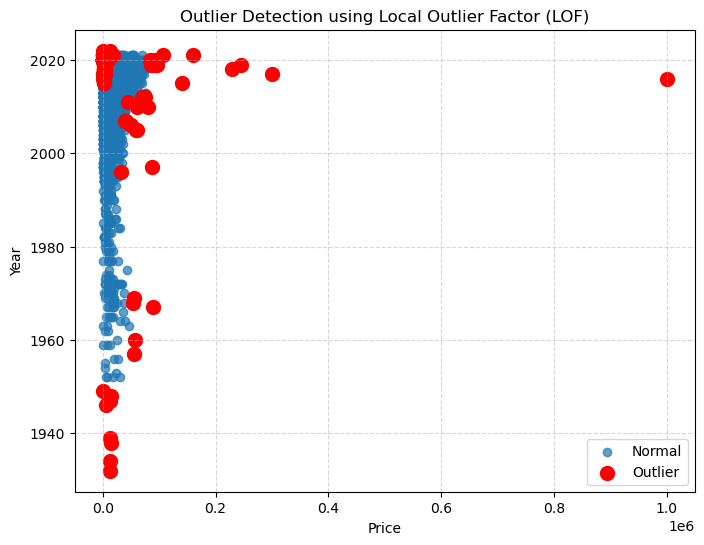

In [37]:
# Apply LOF
# n_neighbors controls the number of neighbors to use for local density
lof = LocalOutlierFactor(n_neighbors=50, contamination=0.02)  # contamination = expected fraction of outliers
labels = lof.fit_predict(X_scaled)  # -1 = outlier, 1 = normal point
scores = lof.negative_outlier_factor_

# Add LOF labels and scores to the dataframe
df_sample['LOF_label'] = labels
df_sample['LOF_score'] = scores

# Identify outliers
outliers = df_sample[df_sample['LOF_label'] == -1]

print("Outliers detected by LOF (subsample):\n")
print(outliers)

# Plot results
plt.figure(figsize=(8, 6))

# Normal points
plt.scatter(
    df_sample[df_sample['LOF_label'] != -1]['price'],
    df_sample[df_sample['LOF_label'] != -1]['year'],
    alpha=0.7,
    label="Normal"
)

# Outliers
plt.scatter(
    df_sample[df_sample['LOF_label'] == -1]['price'],
    df_sample[df_sample['LOF_label'] == -1]['year'],
    color='red',
    s=100,
    label="Outlier"
)

plt.xlabel("Price")
plt.ylabel("Year")
plt.title("Outlier Detection using Local Outlier Factor (LOF)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


Compared to DBSCAN, in this case we obtain a series of outliers that do not depend on any cluster, only on local density, so we find that some records with higher age and lower price should be considered anomalies in the dataset (their local density is low).

The LOF parameters are as follows:

n_neighbors: Number of neighbors that LOF considers when calculating local density.
 - Increase n_neighbors → density is calculated over a larger area → fewer points are considered outliers → less restrictive.
 - Decrease n_neighbors → more sensitive to small anomalies → more restrictive.

Contamination: Expected fraction of outliers in the dataset.
 - Increase contamination → more points are labeled as outliers → more restrictive.
  - Decrease contamination → fewer points labeled as outliers → less restrictive.

#### 3.4 Distance-based Method

Now we are going to detect outliers using a distance-based method. Each point’s Euclidean distance to the centroid (mean of the variables) is calculated, and points that are significantly farther than the rest are considered outliers. By adjusting the threshold, we can control how strict or lenient the detection is. This method works well when extreme values are isolated from the main cluster

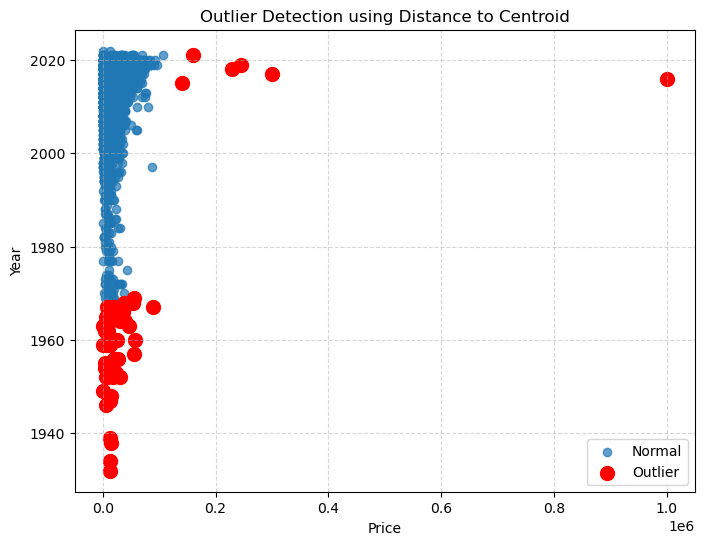

In [41]:
# Compute the centroid (mean)
centroid = X_scaled.mean(axis=0)

# Compute Euclidean distances to centroid
distances = np.linalg.norm(X_scaled - centroid, axis=1)

# Define threshold (99th percentile)
threshold = np.percentile(distances, 99)  # top 1% distances are outliers

# Label outliers
df_sample['Distance_outlier'] = distances > threshold

# Identify outliers
outliers = df_sample[df_sample['Distance_outlier'] == True]

# Plot results
plt.figure(figsize=(8, 6))

# Normal points
plt.scatter(
    df_sample[df_sample['Distance_outlier'] == False]['price'],
    df_sample[df_sample['Distance_outlier'] == False]['year'],
    alpha=0.7,
    label="Normal"
)

# Outliers
plt.scatter(
    df_sample[df_sample['Distance_outlier'] == True]['price'],
    df_sample[df_sample['Distance_outlier'] == True]['year'],
    color='red',
    s=100,
    label="Outlier"
)

plt.xlabel("Price")
plt.ylabel("Year")
plt.title("Outlier Detection using Distance to Centroid")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In this case, it appears as if there is an imaginary circle surrounding the centroid, in which all external points are considered outliers, specifically the lowest years and highest prices. To adjust how strict we want to be, we simply need to change the percentile of the code (a lower percentile will make us stricter).

#### 3.5 Categorical Variables

In this example, we analyze the categorical variable manufacturer to identify potential outliers.
Since categorical features don’t have numerical distributions, outliers are typically represented by rare or uncommon categories.

To detect these rare categories, we visualize the frequency of each manufacturer using a bar chart. Categories with significantly lower counts may indicate unusual manufacturers, data entry errors, or values that should be grouped or cleaned. This helps improve data quality before performing further analysis or modeling.

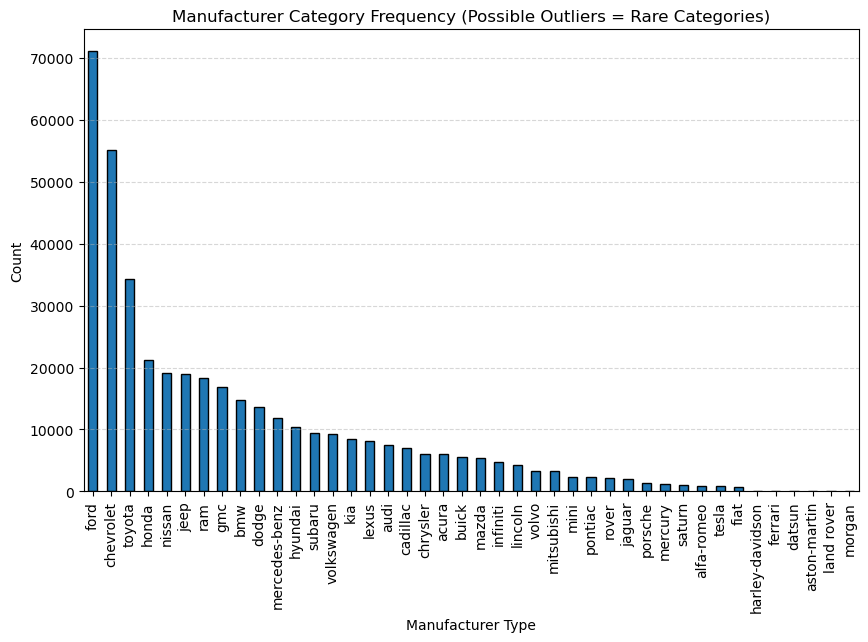

Manufacturer category frequencies:

manufacturer
ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427
infiniti            4802
lincoln             4220
volvo               3374
mitsubishi          3292
mini                2376
pontiac             2288
rover               2113
jaguar              1946
porsche             1384
mercury             1184
saturn              1090
alfa-romeo           897
tesla                868
fiat                 792
harley-davidson      153
ferrari               95
d

In [45]:
# Count the frequency of each fuel category
fuel_counts = data['manufacturer'].value_counts()

# Plot category frequencies
plt.figure(figsize=(10, 6))
fuel_counts.sort_values(ascending=False).plot(kind='bar', edgecolor='black')

plt.title("Manufacturer Category Frequency (Possible Outliers = Rare Categories)")
plt.xlabel("Manufacturer Type")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

# Show table for additional inspection
print("Manufacturer category frequencies:\n")
print(fuel_counts)


In the bar chart, we see that there are up to six categories that are very poorly represented. 
In the table, we can see how many times they appear in the dataset. In this case, Morgan only appears three times, so we can consider it a categorical outlier compared to the rest of the categories.